In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
PROC_DIR = Path('../input/processed')

train_data = pd.read_parquet(PROC_DIR / 'train_processed.parquet', engine='fastparquet')
test_data = pd.read_parquet(PROC_DIR / 'test_processed.parquet', engine='fastparquet')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    category
 2   Sex        891 non-null    category
 3   Age        891 non-null    float64 
 4   SibSp      891 non-null    int64   
 5   Parch      891 non-null    int64   
 6   Fare       891 non-null    float64 
 7   Embarked   891 non-null    category
 8   Title      891 non-null    category
 9   has_cabin  891 non-null    int64   
dtypes: category(4), float64(2), int64(4)
memory usage: 45.6 KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pclass     418 non-null    category
 1   Sex        418 non-null    category
 2   Age        418 non-null    float64 
 3   SibSp      418 non-null    int64   
 4   Parch      418 non-null    int64   
 5   Fare       418 non-null    float64 
 6   Embarked   418 non-null    category
 7   Title      418 non-null    category
 8   has_cabin  418 non-null    int64   
dtypes: category(4), float64(2), int64(3)
memory usage: 18.2 KB


# 1. Feature Engineering

## Creating additional features

* is_child
* family_size
* is_alone
* sex * pclass (Interaction Feature)
* fare_per_person

In [5]:
train_data['is_child'] = (train_data['Age'] < 16).astype(int)
test_data['is_child'] = (test_data['Age'] < 16).astype(int)

train_data['family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['family_size'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['is_alone'] = (train_data['family_size'] == 1).astype(int)
test_data['is_alone'] = (test_data['family_size'] == 1).astype(int)

train_data['sex_pclass'] = train_data['Sex'].astype(str) + '_' + train_data['Pclass'].astype(str)
test_data['sex_pclass'] = test_data['Sex'].astype(str) + '_' + test_data['Pclass'].astype(str)

train_data['fare_per_person'] = train_data['Fare'] / train_data['family_size']
test_data['fare_per_person'] = test_data['Fare'] / test_data['family_size']


In [6]:
train_data['sex_pclass'] = pd.Categorical(train_data['sex_pclass'])
test_data['sex_pclass'] = pd.Categorical(test_data['sex_pclass'])

## Checking for correlations

In [7]:
# Specifying numerical and categorical columns
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare', 'family_size', 'fare_per_person']
categorical_columns = ['Sex', 'Embarked', 'Title', 'is_child', 'is_alone', 'sex_pclass', 'has_cabin']

* Numeric <--> Numeric
- No strong relationships found

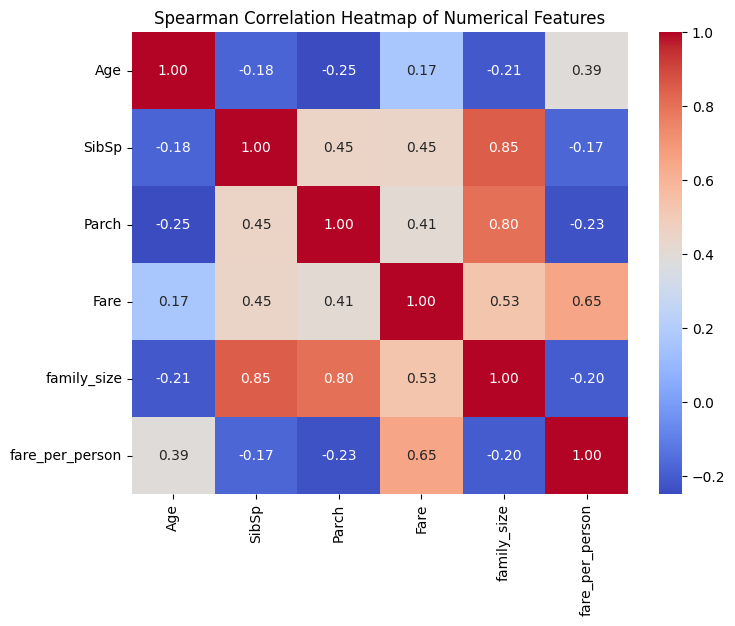

In [8]:
# Use only the numerical features specified in numerical_columns
numerical_features = train_data[numerical_columns]
spearman_correlations = numerical_features.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap of Numerical Features")
plt.show()

In [9]:
# Dropping SibSp and Parch given that family_size and is_alone are better representations of the data 
# and they are highly correlated with each other, also dropping fare given that 
# fare_per_person is a better representation of the data
train_data.drop(columns=['SibSp', 'Parch', 'Fare'], inplace=True)
test_data.drop(columns=['SibSp', 'Parch', 'Fare'], inplace=True)

numerical_columns = ['Age', 'fare_per_person', 'family_size']

* Numeric <--> Categorical

In [10]:
# Check normality per group using Shapiro-Wilk test for each numeric-categorical pair
from scipy.stats import shapiro

summary_results = []
for num_col in numerical_columns:
    for cat_col in categorical_columns:
        pass_count = 0
        fail_count = 0
        for cat_value, group in train_data.groupby(cat_col, observed=False):
            group_values = group[num_col].dropna()
            if 3 <= len(group_values) <= 5000:  # Shapiro-Wilk suggested sample size
                _, p = shapiro(group_values)
                if p > 0.05:
                    pass_count += 1
                else:
                    fail_count += 1
            # If the group is too small or too large, skip it in the summary
        summary_results.append({
            "Numerical Feature": num_col,
            "Categorical Feature": cat_col,
            "Groups Passing (p>0.05)": pass_count,
            "Groups Failing (p<=0.05)": fail_count
        })

normality_summary_df = pd.DataFrame(summary_results)
display(normality_summary_df)

/Users/danielanzures/Documents/titanic/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,Numerical Feature,Categorical Feature,Groups Passing (p>0.05),Groups Failing (p<=0.05)
0,Age,Sex,0,2
1,Age,Embarked,0,3
2,Age,Title,3,3
3,Age,is_child,0,2
4,Age,is_alone,0,2
5,Age,sex_pclass,3,3
6,Age,has_cabin,1,1
7,fare_per_person,Sex,0,2
8,fare_per_person,Embarked,0,3
9,fare_per_person,Title,1,5


In [11]:
'''
All the groups fail the Shapiro-Wilk test, 
so we can conclude that the data is not normally distributed,
therefore we will use the Kruskal-Wallis test to check for differences between groups
instead of ANOVA.
'''

'\nAll the groups fail the Shapiro-Wilk test, \nso we can conclude that the data is not normally distributed,\ntherefore we will use the Kruskal-Wallis test to check for differences between groups\ninstead of ANOVA.\n'

* No strong relationships found

In [12]:
kruskal_rows = []
for num_col in numerical_columns:
    for cat_col in categorical_columns:
        # Prepare groups by categorical values, explicitly set observed=False to suppress FutureWarning
        groups = [group[num_col].dropna() for name, group in train_data.groupby(cat_col, observed=False)]
        group_sizes = [len(g) for g in groups]
        n_total = sum(group_sizes)
        k = len(groups)
        if k > 1:
            # Kruskal-Wallis test
            try:
                h_stat, p_value = stats.kruskal(*groups)
            except ValueError:
                # This occurs if any group is empty after dropna
                h_stat, p_value = float('nan'), float('nan')
            # Calculate epsilon-squared (effect size)
            # Epsilon-squared = (H - k + 1) / (n - k)
            if n_total > k:
                epsilon_squared = (h_stat - k + 1) / (n_total - k)
            else:
                epsilon_squared = float('nan')
            kruskal_rows.append({
                'Numerical Feature': num_col,
                'Categorical Feature': cat_col,
                'H-statistic': h_stat,
                'p-value': p_value,
                'Epsilon squared': epsilon_squared
            })

kruskal_df = pd.DataFrame(kruskal_rows)
# Format the H-statistic, p-value, and epsilon squared columns for better readability
kruskal_df['H-statistic'] = kruskal_df['H-statistic'].map(lambda x: f"{x:.4f}" if pd.notnull(x) else "nan")
kruskal_df['p-value'] = kruskal_df['p-value'].map(lambda x: f"{x:.4g}" if pd.notnull(x) else "nan")
kruskal_df['Epsilon squared'] = kruskal_df['Epsilon squared'].map(lambda x: f"{x:.4f}" if pd.notnull(x) else "nan")

display(kruskal_df)

,Numerical Feature,Categorical Feature,H-statistic,p-value,Epsilon squared
0,Age,Sex,11.1255,0.0008515,0.0114
1,Age,Embarked,17.8304,0.0001343,0.0178
2,Age,Title,273.2571,8.551e-49,0.2943
3,Age,is_child,235.8335,3.186e-53,0.2642
4,Age,is_alone,20.4087,6.254e-06,0.0218
5,Age,sex_pclass,183.8086,8.22e-38,0.2020
6,Age,has_cabin,64.8479,8.091e-16,0.0718
7,fare_per_person,Sex,3.0388,0.0813,0.0023
8,fare_per_person,Embarked,53.2547,2.728e-12,0.0577
9,fare_per_person,Title,70.8877,6.972e-09,0.0628


In [13]:
'''
family_size and is_alone are not significantly different from each other, 
but we will keep both given is_alone is encoding an importance on the jump of
1 to 2 people in the family.
'''

'\nfamily_size and is_alone are not significantly different from each other, \nbut we will keep both given is_alone is encoding an importance on the jump of\n1 to 2 people in the family.\n'

* categorical <--> categorical

In [14]:
# Calculate Cramér's V for each pair of categorical (and Pclass) columns

# Include 'Pclass' as a categorical feature here for Cramér's V calculations
categorical_plus_pclass = categorical_columns + ['Pclass']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return float('nan')
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Handle degrees of freedom reduction for bias correction (optional)
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denominator = min((kcorr-1), (rcorr-1))
    if denominator == 0:
        # No association possible, or one variable is constant
        return float('nan')
    return np.sqrt(phi2corr / denominator)

cramers_rows = []
for cat1, cat2 in combinations(categorical_plus_pclass, 2):
    v = cramers_v(train_data[cat1], train_data[cat2])
    cramers_rows.append({
        'Categorical Feature 1': cat1,
        'Categorical Feature 2': cat2,
        "Cramér's V": v
    })

cramersv_df = pd.DataFrame(cramers_rows)
# Format the Cramér's V column for better readability
cramersv_df["Cramér's V"] = cramersv_df["Cramér's V"].map(lambda x: f"{x:.4f}" if pd.notnull(x) else "nan")

display(cramersv_df)

,Categorical Feature 1,Categorical Feature 2,Cramér's V
0,Sex,Embarked,0.1107
1,Sex,Title,0.9894
2,Sex,is_child,0.0918
3,Sex,is_alone,0.3020
4,Sex,sex_pclass,0.9977
5,Sex,has_cabin,0.1364
6,Sex,Pclass,0.1297
7,Embarked,Title,0.1436
8,Embarked,is_child,0.0000
9,Embarked,is_alone,0.1104


* Sex and title are highly correlated, so we will drop sex given that title contains more information

In [15]:
# Drop 'Sex' column
train_data = train_data.drop(columns=['Sex'])
test_data = test_data.drop(columns=['Sex'])

* ordinal <--> numerical

In [16]:
# Calculate Spearman correlation between 'Pclass' and numerical columns

# Identify numerical columns (excluding 'Pclass' itself)
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols if col != 'Pclass']

# Calculate Spearman correlation and p-values for each
from scipy.stats import spearmanr

spearman_results = []
for col in numerical_cols:
    corr, pval = spearmanr(train_data['Pclass'], train_data[col], nan_policy='omit')
    spearman_results.append({
        'Numerical Feature': col,
        "Spearman's rho": corr,
        'p-value': pval
    })

spearman_df = pd.DataFrame(spearman_results)
# Format results for readability
spearman_df["Spearman's rho"] = spearman_df["Spearman's rho"].map(lambda x: f"{x:.4f}" if pd.notnull(x) else "nan")
spearman_df["p-value"] = spearman_df["p-value"].map(lambda x: f"{x:.4g}" if pd.notnull(x) else "nan")

display(spearman_df)


,Numerical Feature,Spearman's rho,p-value
0,Survived,-0.3397,1.688e-25
1,Age,-0.4129,5.224e-38
2,has_cabin,-0.6833,1.458e-123
3,is_child,0.1268,0.0001473
4,family_size,-0.0757,0.02384
5,is_alone,0.1359,4.709e-05
6,fare_per_person,-0.7682,2.252e-174


# 2. Model Training

In [17]:
train_data['fare_per_person'] = np.log1p(train_data['fare_per_person'])
test_data['fare_per_person'] = np.log1p(test_data['fare_per_person'])

In [18]:
y_train = train_data['Survived']
X_train = train_data.drop(columns=['Survived'])

X_test = test_data

In [19]:
# Creating separate copies for grouped data given XGBoost and other models
# benefit from non-grouped data
X_train_grouped = X_train.copy()
X_test_grouped = X_test.copy()

In [20]:
# Group rare Title values (frequency < 15) into 'Other' category for X_train_grouped
title_counts = X_train_grouped['Title'].value_counts()
rare_titles = set(title_counts[title_counts < 15].index)
common_titles = set(title_counts[title_counts >= 15].index)
X_train_grouped['Title'] = X_train_grouped['Title'].apply(lambda t: 'Other' if t in rare_titles else t)

# Apply the same transformation to X_test:
#  - If a title was rare in the training set, set to 'Other'
#  - If a title wasn't seen in training set at all, set to 'Other'
X_test_grouped['Title'] = X_test_grouped['Title'].apply(lambda t: t if t in common_titles else 'Other')

In [21]:
from sklearn.preprocessing import StandardScaler

num_features = ['Age', 'family_size', 'fare_per_person']
cat_features = ['Embarked', 'Title', 'sex_pclass']
bin_features = ['is_child', 'is_alone', 'has_cabin']
ord_features = ['Pclass']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features),
        ('bin', 'passthrough', bin_features),
        ('ord', OrdinalEncoder(), ord_features)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train_grouped)
X_test_scaled = preprocessor.transform(X_test_grouped)

In [22]:
num_features = ['Age', 'family_size', 'fare_per_person']
cat_features = ['Embarked', 'Title', 'sex_pclass']
bin_features = ['is_child', 'is_alone', 'has_cabin']
ord_features = ['Pclass']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features),
        ('bin', 'passthrough', bin_features),
        ('ord', OrdinalEncoder(), ord_features)
    ]
)

X_train_ohe = preprocessor.fit_transform(X_train_grouped)
X_test_ohe = preprocessor.transform(X_test_grouped)

## 2.1 Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define three grids: L1, L2, and elasticnet
param_grid = [
    {
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [1.0],  # l1_ratio 1 for l1 penalty
        "class_weight": [None, "balanced"]
    },
    {
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0],  # l1_ratio 0 for l2 penalty
        "class_weight": [None, "balanced"]
    },
    {
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.4, 0.6, 0.8],  # l1_ratio required for elasticnet
        "class_weight": [None, "balanced"]
    }
]

logreg = LogisticRegression(max_iter=5000)

grid = GridSearchCV(
    logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fit the grid search to the scaled training data
grid.fit(X_train_scaled, y_train)

# Predict probabilities for the positive class
y_train_pred_prob = grid.predict_proba(X_train_scaled)[:, 1]

# Evaluate the ROC-AUC on the training set
roc_auc = roc_auc_score(y_train, y_train_pred_prob)

print(f'Best parameters: {grid.best_params_}')
print(f'Best cross-validated ROC-AUC: {grid.best_score_:.4f}')
print(f'Training ROC-AUC: {roc_auc:.4f}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0, 'solver': 'saga'}
Best cross-validated ROC-AUC: 0.8737
Training ROC-AUC: 0.8820


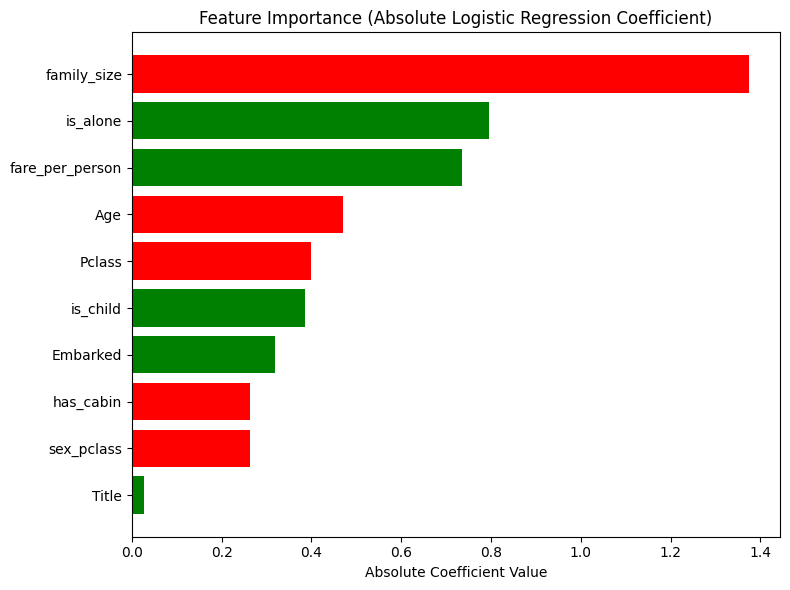

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Try to get feature names safely, fallback to numeric names if fails
if hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
elif hasattr(X_train_scaled, "shape"):
    feature_names = [f"Feature {i}" for i in range(X_train_scaled.shape[1])]
else:
    raise RuntimeError("Cannot determine feature names from X_train or X_train_scaled.")

# Get the trained LogisticRegression estimator (handling pipelines)
best_model = grid.best_estimator_
if hasattr(best_model, "coef_"):
    coefs = best_model.coef_[0]
else:
    try:
        from sklearn.linear_model import LogisticRegression
        lr_candidates = [est for name, est in best_model.named_steps.items() if isinstance(est, LogisticRegression)]
        if len(lr_candidates) == 0:
            raise RuntimeError("Could not find LogisticRegression in the best_estimator_")
        coefs = lr_candidates[0].coef_[0]
    except Exception:
        raise RuntimeError("Could not find LogisticRegression in the best_estimator_")

# Fix for "All arrays must be of the same length" -- ensure same length for feature_names and coefs
if len(feature_names) != len(coefs):
    min_len = min(len(feature_names), len(coefs))
    feature_names = feature_names[:min_len]
    coefs = coefs[:min_len]

# Build DataFrame with needed info
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Importance_abs": np.abs(coefs)
})
feat_imp_df = feat_imp_df.sort_values("Importance_abs", ascending=True)

# Set color: positive=green, negative=red
colors = np.where(feat_imp_df["Coefficient"] >= 0, "green", "red")

plt.figure(figsize=(8, 6))
plt.barh(
    feat_imp_df["Feature"],
    feat_imp_df["Importance_abs"],
    color=colors
)
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance (Absolute Logistic Regression Coefficient)")
plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import accuracy_score
import numpy as np

# Find best threshold for accuracy score using training data
y_train_proba = grid.predict_proba(X_train_scaled)[:, 1]
thresholds = np.linspace(0, 1, 101)
accuracies = [accuracy_score(y_train, y_train_proba >= t) for t in thresholds]
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
print(f"Best accuracy threshold on train data: {best_threshold:.3f}")

# Predict on test set using probability threshold
y_test_proba = grid.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Add predicted Survived values to X_test as 'Survived'
X_test_with_pred = X_test.copy()
X_test_with_pred['Survived'] = y_test_pred

# Add PassengerId column from the raw test.csv file
PATH_INPUT = Path('../input/raw')
raw_test = pd.read_csv(PATH_INPUT / 'test.csv')
X_test_with_pred['PassengerId'] = raw_test['PassengerId'].values

# Reorder columns if desired: PassengerId first, then rest
cols = ['PassengerId', 'Survived'] + [col for col in X_test_with_pred.columns if col not in ['PassengerId', 'Survived']]
X_test_with_pred = X_test_with_pred[cols]

Best accuracy threshold on train data: 0.550


In [33]:
PATH_OUTPUT = Path('../output')

lr_submission = X_test_with_pred[['PassengerId', 'Survived']]
lr_submission.to_csv(PATH_OUTPUT / 'lr_submission.csv', index=False)

## 2.2 Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'bootstrap': [True]
}

rf_clf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0,
    error_score='raise'
)

rf_grid.fit(X_train_ohe, y_train)

print(f'Best parameters: {rf_grid.best_params_}')
print(f'Best cross-validated accuracy score: {rf_grid.best_score_:.4f}')

Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
Best cross-validated accuracy score: 0.8362


In [37]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Get predicted probabilities for the positive class on the holdout data
rf_best = rf_grid.best_estimator_
y_prob_test = rf_best.predict_proba(X_test_ohe)[:, 1]

# Use train set to find best threshold for accuracy
prob_train = rf_best.predict_proba(X_train_ohe)[:, 1]
precisions, recalls, thresh = precision_recall_curve(y_train, prob_train)

thresholds = []
acc_scores = []
for t in thresh:
    y_pred = (prob_train >= t).astype(int)
    acc = accuracy_score(y_train, y_pred)
    thresholds.append(t)
    acc_scores.append(acc)

max_idx = acc_scores.index(max(acc_scores))
best_threshold = thresholds[max_idx]
print(f'Best threshold for maximizing accuracy (on train): {best_threshold:.4f}, Accuracy: {acc_scores[max_idx]:.4f}')

# Apply best threshold to get test predictions
y_test_pred = (y_prob_test >= best_threshold).astype(int)

# Read original test.csv to get PassengerId & merge with pred
raw_test = pd.read_csv("../input/raw/test.csv")
X_test_with_pred = X_test.copy()
X_test_with_pred["PassengerId"] = raw_test["PassengerId"]
X_test_with_pred["Survived"] = y_test_pred


Best threshold for maximizing accuracy (on train): 0.5463, Accuracy: 0.8810


In [36]:
PATH_OUTPUT = Path('../output')

rf_submission = X_test_with_pred[['PassengerId', 'Survived']]
rf_submission.to_csv(PATH_OUTPUT / 'rf_submission.csv', index=False)

## 2.3 XGBoost

In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings

# Suppress 'use_label_encoder' user warnings from xgboost globally
warnings.filterwarnings(
    "ignore",
    message=r".*use_label_encoder.*",
    category=UserWarning,
    module="xgboost"
)

# Define a simple parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [300, 600, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.3, 1.0],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [1, 3, 10],
}


# Remove the deprecated 'use_label_encoder' parameter to avoid the warning
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_grid = GridSearchCV(
    xgb_clf,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_ohe, y_train)
print('Best XGBoost params:', xgb_grid.best_params_)
print('Best XGBoost train accuracy:', xgb_grid.best_score_)

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best XGBoost params: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 1000, 'reg_lambda': 1, 'subsample': 0.7}
Best XGBoost train accuracy: 0.851861151214613


In [50]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get predicted probabilities for the positive class
xgb_probs = xgb_grid.predict_proba(X_train_ohe)[:, 1]

# Search for best threshold based on accuracy
thresholds = np.linspace(0, 1, 101)
best_acc = 0
best_thresh = 0.5

for t in thresholds:
    xgb_preds = (xgb_probs >= t).astype(int)
    acc = accuracy_score(y_train, xgb_preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

# Apply best threshold to get test predictions
xgb_test_probs = xgb_grid.predict_proba(X_test_ohe)[:, 1]
xgb_test_pred = (xgb_test_probs >= best_thresh).astype(int)

# Read original test.csv to get PassengerId & merge with pred
raw_test = pd.read_csv("../input/raw/test.csv")
X_test_xgb_with_pred = X_test.copy()
X_test_xgb_with_pred["PassengerId"] = raw_test["PassengerId"]
X_test_xgb_with_pred["Survived"] = xgb_test_pred

print(f"Best threshold based on accuracy: {best_thresh:.2f}")
print(f"Best accuracy at this threshold: {best_acc:.4f}")


Best threshold based on accuracy: 0.40
Best accuracy at this threshold: 0.9046


In [51]:
PATH_OUTPUT = Path('../output')

xg_submission = X_test_xgb_with_pred[['PassengerId', 'Survived']]
xg_submission.to_csv(PATH_OUTPUT / 'xgboost_submission.csv', index=False)

## 2.4 Neural Network